# Enunciado
## Cálculo de la duración de un proyecto usando el Método de Montecarlo

>Considere el proyecto cuya información se adjunta.
> 1. Dibuje el grafo PERT del proyecto.
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.
> 3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.
> 4. Determina la duración media y la desviación típica de la duración del proyecto.
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%.

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph




Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 254 (delta 31), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (254/254), 9.69 MiB | 22.86 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import numpy as np
import matplotlib as plt
%matplotlib inline

datos_enunciado = pd.DataFrame([
#  actividad, predecesora, duracion media, desviación típica
     ('A',    '---  ', 10, 1.5 ),
     ('B',    '---  ',  5, 0.4 ),
     ('C',    'A    ',  6, 0.8 ),
     ('D',    'A    ',  2, 0.7 ),
     ('E',    'B,C,D',  7, 1.8 ),
     ('F',    'B,D  ',  8, 0.8 ),
     ('G',    'E,F  ',  4, 1.4 ),
     ('H',    'B    ',  7, 1.6 ),
] ,columns=['activity', 'predecessor', 'mean', 'stdev']).set_index('activity')

datos_enunciado

,predecessor,mean,stdev
activity,,,
A,---,10,1.5
B,---,5,0.4
C,A,6,0.8
D,A,2,0.7
E,"B,C,D",7,1.8
F,"B,D",8,0.8
G,"E,F",4,1.4
H,B,7,1.6


## Solución
### Apartado 1
> 1. Dibuje el grafo PERT del proyecto.

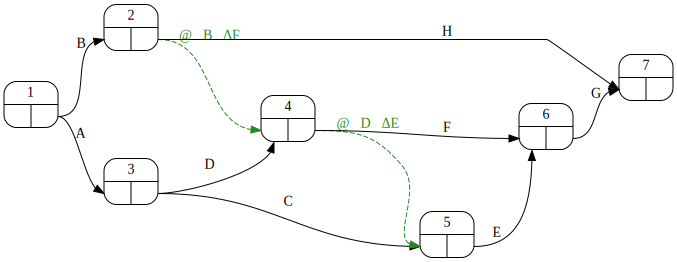

In [3]:
datos_proyecto =  datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
proyecto = prelaciones.create_project()
proyecto.pert()

### Apartado 2
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.


$t_1 = 0$

$t_2 = t_1 + B$

$t_3 = t_1 + A$

$ t_4 = \max \begin{Bmatrix} t_2 + d_{@∇B⤑ΔF} \\ t_3 + D \end{Bmatrix} $

$ t_5 = \max \begin{Bmatrix} t_3 + C \\ t_4 + d_{@∇D⤑ΔE} \end{Bmatrix} $

$ t_6 = \max \begin{Bmatrix} t_5 + E \\ t_4 + F \end{Bmatrix} $

$ t_7 = \max \begin{Bmatrix} t_6+ G \\ t_2 + H \end{Bmatrix} $


### Apartado 3
> 3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.

#### Generación aleatoria de las duraciones de las actividades

In [4]:
number_of_samples = 1000

In [5]:
activity_names = datos_proyecto.index
duration = pd.DataFrame([np.random.normal(size = number_of_samples,
                                          loc  = datos_proyecto.loc[task, 'mean',],
                                          scale= datos_proyecto.loc[task, 'stdev'])
                         for task in activity_names
                        ],
                        index=activity_names).T

In [6]:
duration.head()

activity,A,B,C,D,E,F,G,H
0,10.558129,4.648880,5.602289,2.141184,7.024245,8.090366,4.055525,7.251469
1,8.878042,5.416644,5.690947,2.221879,6.193626,7.984919,0.612189,4.457222
2,8.786097,4.970446,5.489915,2.050943,4.976566,8.485805,2.140878,7.949512
3,10.286145,5.411713,5.092258,3.178128,6.136950,7.937790,5.052167,6.501761
4,10.620579,5.286649,6.816400,1.706156,10.738933,6.863102,7.765288,7.176829


#### Cálculo de los tiempos tempranos

In [7]:
def row_max(A,B):
    return pd.concat([A,B], axis=1).max(axis=1)

In [8]:
t_early = duration.copy()
t_early.eval("""t_1 = 0
                t_2 = t_1 + B

                t_3 = t_1 + A

                input_D = t_3 + D
                input_f_B_F = t_2 + 0
                t_4 = @row_max(input_D, input_f_B_F)

                input_C = t_3 + C
                input_f_D_E = t_4 + 0
                t_5 = @row_max(input_C, input_f_D_E)

                input_E = t_5 + E
                input_F = t_4 + F
                t_6 = @row_max(input_E, input_F)

                input_G = t_6 + G
                input_H = t_2 + H
                t_7 = @row_max(input_G, input_H)
                """, inplace=True)

In [9]:
tiempos_nodos = ['t_'+ str(num) for num in range(1, 8)]
t_early.loc[0:10, : ]

activity,A,B,C,D,E,F,G,H,t_1,t_2,t_3,input_D,input_f_B_F,t_4,input_C,input_f_D_E,t_5,input_E,input_F,t_6,input_G,input_H,t_7
0,10.558129,4.648880,5.602289,2.141184,7.024245,8.090366,4.055525,7.251469,0,4.648880,10.558129,12.699313,4.648880,12.699313,16.160418,12.699313,16.160418,23.184663,20.789679,23.184663,27.240188,11.900350,27.240188
1,8.878042,5.416644,5.690947,2.221879,6.193626,7.984919,0.612189,4.457222,0,5.416644,8.878042,11.099921,5.416644,11.099921,14.568989,11.099921,14.568989,20.762614,19.084839,20.762614,21.374803,9.873866,21.374803
2,8.786097,4.970446,5.489915,2.050943,4.976566,8.485805,2.140878,7.949512,0,4.970446,8.786097,10.837040,4.970446,10.837040,14.276011,10.837040,14.276011,19.252577,19.322845,19.322845,21.463723,12.919958,21.463723
3,10.286145,5.411713,5.092258,3.178128,6.136950,7.937790,5.052167,6.501761,0,5.411713,10.286145,13.464273,5.411713,13.464273,15.378403,13.464273,15.378403,21.515353,21.402063,21.515353,26.567521,11.913474,26.567521
4,10.620579,5.286649,6.816400,1.706156,10.738933,6.863102,7.765288,7.176829,0,5.286649,10.620579,12.326735,5.286649,12.326735,17.436979,12.326735,17.436979,28.175912,19.189837,28.175912,35.941201,12.463479,35.941201
5,13.217127,4.595243,6.834840,1.640446,8.082553,7.939778,1.654781,6.549236,0,4.595243,13.217127,14.857572,4.595243,14.857572,20.051966,14.857572,20.051966,28.134519,22.797350,28.134519,29.789300,11.144479,29.789300
6,11.398998,4.841570,6.851254,2.783597,9.149880,7.613554,4.077131,6.924641,0,4.841570,11.398998,14.182595,4.841570,14.182595,18.250252,14.182595,18.250252,27.400133,21.796149,27.400133,31.477264,11.766210,31.477264
7,7.956721,4.687780,6.410048,2.372012,6.111163,8.427847,3.952753,7.041842,0,4.687780,7.956721,10.328733,4.687780,10.328733,14.366769,10.328733,14.366769,20.477932,18.756580,20.477932,24.430685,11.729622,24.430685
8,10.614097,4.968235,5.866319,1.603504,6.889756,8.156459,1.521679,6.688804,0,4.968235,10.614097,12.217601,4.968235,12.217601,16.480415,12.217601,16.480415,23.370172,20.374060,23.370172,24.891851,11.657039,24.891851
9,9.338145,5.491201,6.317924,0.138278,7.715324,7.006407,2.232427,7.172609,0,5.491201,9.338145,9.476423,5.491201,9.476423,15.656069,9.476423,15.656069,23.371393,16.482830,23.371393,25.603819,12.663810,25.603819


### Apartado 4
> 4. Determina la duración media y la desviación típica de la duración del proyecto.

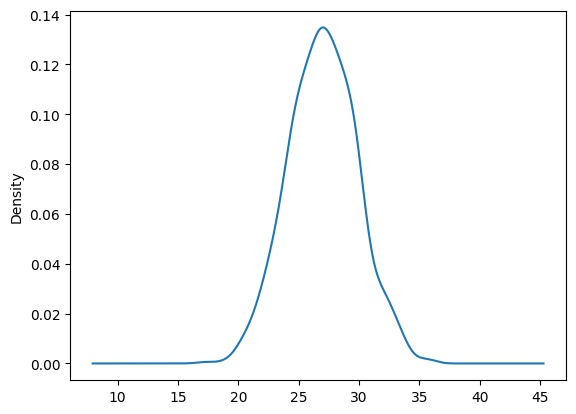

In [10]:
t_early['t_7'].plot(kind='density');

In [11]:
t_early['t_7'].describe()

,t_7
count,1000.000000
mean,26.990929
std,2.827415
min,17.265273
25%,25.022235
50%,26.989773
75%,28.949288
max,35.941201


In [12]:
f"La duración media del proyecto es:{t_early['t_7'].mean()}, la desviación típica de la duración del proyecto es:{t_early['t_7'].std()}"

'La duración media del proyecto es:26.990929426498603, la desviación típica de la duración del proyecto es:2.8274151153515463'

La desviación típica de la duración del proyecto es:

### Apartado 5
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%.

Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 98% de las muestras.

In [13]:
t_early['t_7'].sort_values(ascending=True).iloc[int(0.98*number_of_samples)]

32.98718431766411

O bien, utilizando la función `quantile`

In [14]:
t_early['t_7'].quantile(q=0.98, interpolation='higher')

32.98718431766411